In [1]:
%matplotlib inline
import os, sys, gc
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
from tqdm import tqdm
from numpy import array

load_dir = 'lo-shot-dinos-classification-genetic-pilot'
print(os.listdir(load_dir))

['b', 'html-button-response.csv', 'participants.csv', 'survey-multi-choice.csv']


In [44]:
ignore = ['w93e05c8', 'w8f3a5e6', 'w72ff099', 'w6189e36', 'w3cbe79c',
       'w86d39ac', 'wfc8e96c', 'wf2fae6e', 'w2c152d2', 'wbfb9c6f',]
       #'wcfe7234', 'wb38724c', 'we815cde', 'wb2873cd', 'wf369503']
button_response_data = pd.read_csv("{}/html-button-response.csv".format(load_dir))
responses = button_response_data[(button_response_data.task == 'testing_c1_categorize') | (button_response_data.task == 'testing_c2_categorize')]
responses = responses[["wid", "task", "response", "target_dino", "label_pair", "manifold_jitter"]]
for wid in ignore:
    responses = responses[responses.wid != wid]
responses["response"] = responses["response"].astype('category',copy=False)
responses["target_dino"] = responses["target_dino"].astype('category',copy=False)
sl =[[array([0., 0., 1.]), array([0.25, 0.25, 0.5 ])],
 [array([0., 0., 1.]), array([0.25, 0.5 , 0.25])],
 [array([0., 0., 1.]), array([0.25, 0.75, 0.  ])],
 [array([0., 0., 1.]), array([0.5, 0.5, 0. ])],
 [array([0.  , 0.25, 0.75]), array([0.25, 0.  , 0.75])],
 [array([0.  , 0.25, 0.75]), array([0.25, 0.25, 0.5 ])],
 [array([0.  , 0.25, 0.75]), array([0.25, 0.5 , 0.25])],
 [array([0.  , 0.25, 0.75]), array([0.25, 0.75, 0.  ])],
 [array([0.  , 0.25, 0.75]), array([0.5, 0. , 0.5])],
 [array([0.  , 0.25, 0.75]), array([0.5 , 0.25, 0.25])],
 [array([0.  , 0.25, 0.75]), array([0.5, 0.5, 0. ])],
 [array([0.  , 0.25, 0.75]), array([0.75, 0.25, 0.  ])],
 [array([0. , 0.5, 0.5]), array([0.25, 0.25, 0.5 ])],
 [array([0. , 0.5, 0.5]), array([0.5, 0. , 0.5])],
 [array([0. , 0.5, 0.5]), array([0.5 , 0.25, 0.25])],
 [array([0.25, 0.25, 0.5 ]), array([0.25, 0.25, 0.5 ])],
 [array([0.25, 0.25, 0.5 ]), array([0.25, 0.5 , 0.25])]]


In [45]:
def agreement(df1, df2):
    agreed=0
    for i in range(20):
        agreed+= set(df1[df1['target_dino']==i]['response'])==set(df2[df2['target_dino']==i]['response'])
    return agreed
subject_dfs=[]
for i in set(responses["label_pair"]):
    r=responses[responses["label_pair"]==i]
    wids=set(r["wid"])
    
    for w in wids:
        subject_dfs.append(r[r["wid"]==w])
agreements=[]
for i in range(len(subject_dfs)):
    subj = subject_dfs[i]
    subjc1 = subj[subj.task == 'testing_c1_categorize']
    subjc2 = subj[subj.task == 'testing_c2_categorize']
#     plt.scatter(subjc1['target_dino'],subjc1['response'])
#     plt.show()
#     plt.scatter(subjc2['target_dino'],subjc2['response'])
#     plt.show()
    agreements.append(agreement(subjc1, subjc2))
print("Mean within-subject agreement between point clouds: {0}".format(np.mean(agreements)/20))

Mean within-subject agreement between point clouds: 0.7407142857142858


In [83]:
np.mean(agreements)

14.814285714285715

0.17526326351652116

In [46]:
n=len(subject_dfs)
ags_mat1=np.empty((n,n))
ags_mat2=np.empty((n,n))

for i in tqdm(range(n)):
    subj1=subject_dfs[i]
    for j in range(i,n):
        subj2=subject_dfs[j]
        ags_mat1[i,j]=ags_mat1[j,i]=agreement(subj1[subj1.task == 'testing_c1_categorize'],subj2[subj2.task == 'testing_c1_categorize'])
        ags_mat2[i,j]=ags_mat2[j,i]=agreement(subj1[subj1.task == 'testing_c2_categorize'],subj2[subj2.task == 'testing_c2_categorize'])

100%|██████████| 70/70 [01:46<00:00,  1.52s/it]


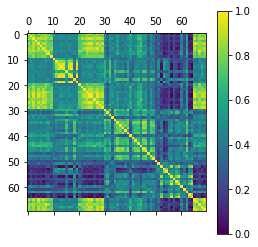

In [47]:
#Inter-subject agreement matrix
plt.matshow((ags_mat1+ags_mat2)/40)
plt.colorbar()

Correlation between inter-subject agreement and similarity of observed labels:  (0.5661291250036837, 1.2959968428422728e-210)


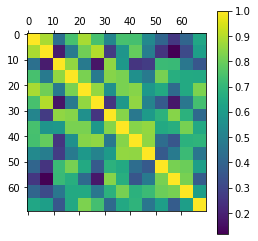

In [131]:
#Inter-trial label_pair similarity matrix
lps=list(set(responses.label_pair))
label_similarity=np.empty((len(subject_dfs),len(subject_dfs)))
for i in range(len(subject_dfs)):
    for j in range(len(subject_dfs)):
        s1=subject_dfs[i]
        s2=subject_dfs[j]
        sl1=array(sl[list(s1.label_pair)[0]]).flatten()
        sl2=array(sl[list(s2.label_pair)[0]]).flatten()
        label_similarity[i,j]=np.sum((sl1*sl2))/(np.linalg.norm(sl1)*np.linalg.norm(sl2))#1/np.sum((np.array(sl[lps[i]])-np.array(sl[lps[j]]))**2)#1/(np.sum((np.array(sl1)-np.array(sl2))**2)+1)#
plt.matshow(label_similarity**3)
plt.colorbar()
from scipy.stats import spearmanr, pearsonr
new_inds=np.triu_indices(n)
print("Correlation between inter-subject agreement and similarity of observed labels: ",pearsonr((ags_mat1+ags_mat2)[new_inds].flatten(), label_similarity[new_inds].flatten()**3))

In [136]:
len(new_inds[0])

2485

In [49]:
joint_mat=ags_mat1+ags_mat2
inds=np.triu_indices(5,1)
isags=[]
for i in range(len(joint_mat)//5):
    isags.append(np.mean(joint_mat[i*5:(i+1)*5,i*5:(i+1)*5][inds])/40)
print("Mean inter-subject agreement:",np.mean(isags))


Mean inter-subject agreement: 0.6817857142857141


In [84]:
np.mean(isags)*40

27.271428571428565

In [54]:
print(np.mean(joint_mat)/40)

0.4731632653061224


In [ ]:
#PLEASE ADD ONE OF THE LINE PLOTS HERE FOR A POINT CLOUD THAT SHOWS ALL 3 CLASSES BEING USED

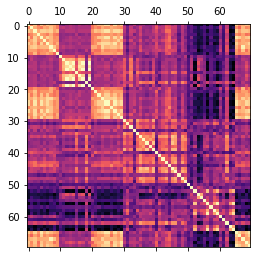

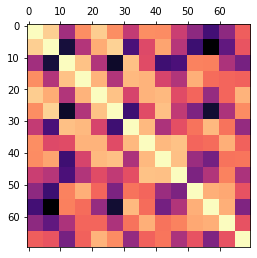

In [50]:
plt.matshow((ags_mat1+ags_mat2)/40, cmap=plt.cm.magma)

plt.matshow(label_similarity**2, cmap=plt.cm.magma)


plt.show()

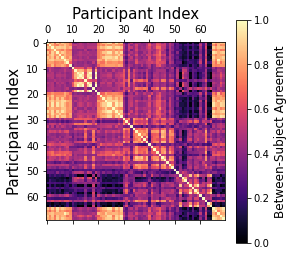

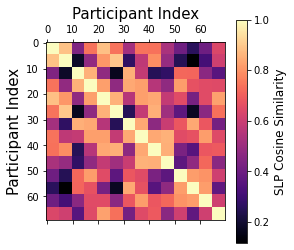

In [127]:
plt.matshow((ags_mat1+ags_mat2)/40, cmap=plt.cm.magma)
plt.ylabel("Participant Index", fontsize=15)
plt.title("Participant Index", fontsize=15)
c=plt.colorbar(ticks=[0.0, 0.2, 0.4, 0.6,0.8,1.0])
c.set_label(label="Between-Subject Agreement", fontsize=12)
plt.savefig("figs/LOSL/heatmap_human.png")
plt.matshow(label_similarity**3, cmap=plt.cm.magma)
plt.ylabel("Participant Index", fontsize=15)
plt.title("Participant Index", fontsize=15)
c=plt.colorbar(ticks=[0.0, 0.2, 0.4, 0.6,0.8,1.0])
c.set_label(label="SLP Cosine Similarity", fontsize=12)
plt.savefig("figs/LOSL/heatmap_label_sims.png")



In [141]:
from scipy.stats import entropy
slps=responses.groupby(['label_pair',"response",])['response'].count()
individuals=responses.groupby(['wid',"response",])['response'].count()
lps=list(set(responses.label_pair))
wids=list(set(responses.wid))

slp_probs=np.array([list(slps[lp]) for lp in lps])
ind_probs=np.array([list(individuals[w]) for w in wids])
print("Average shannon entropy over SLPs: ",np.mean(entropy(slp_probs,axis=1)))
print("Average shannon entropy over subjects: ",np.mean(entropy(ind_probs,axis=1)))

Average shannon entropy over SLPs:  0.9123275966966887
Average shannon entropy over subjects:  0.8293964270895848


In [156]:
slp_probs

array([[ 18,  91,  91],
       [ 25,  87,  88],
       [ 10,  15, 175],
       [ 30,  16, 154],
       [ 11,  99,  90],
       [ 11,  92,  97],
       [ 54,  39, 107],
       [ 95,  23,  82],
       [ 58,  64,  78],
       [ 88,  30,  82],
       [ 34,  92,  74],
       [ 74,  87,  39],
       [ 80,  78,  42],
       [  3, 104,  93]])

In [149]:
from scipy.stats import chi2_contingency

buckets=responses.groupby(['label_pair','target_dino',"response",])['response'].count()
tables=[[[list(buckets[lp,target])] for target in list(set(responses.target_dino))] for lp in lps]

In [155]:
[chi2_contingency(table)[:3] for table in tables]

[(200.56166056166057, 5.610078910182181e-24, 38),
 (206.42758620689656, 4.988147155319361e-25, 38),
 (41.71428571428572, 0.31246238116476216, 38),
 (47.038961038961034, 0.1492636800144876, 38),
 (168.4040404040404, 2.4195067617285735e-18, 38),
 (202.58343180799477, 2.4402509183740334e-24, 38),
 (128.9820805708656, 7.857195471367793e-12, 38),
 (188.14377406931965, 8.952893115319612e-22, 38),
 (132.07283377541998, 2.544041023480042e-12, 38),
 (159.4863266814486, 7.966435662553317e-17, 38),
 (90.46865279601853, 3.6144312337543487e-06, 38),
 (173.13690348173105, 3.7116332848248853e-19, 38),
 (101.55860805860806, 1.062433728645168e-07, 38),
 (170.40529363110008, 1.0969215779117549e-18, 38)]

In [157]:
chi2_contingency(slp_probs)

(721.9419009082384,
 1.804174738861678e-135,
 26,
 array([[42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429],
        [42.21428571, 65.5       , 92.28571429]]))

In [175]:
chi2_contingency(tables)

(3019.1917505602332,
 1.3366506386887225e-252,
 805,
 array([[[[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275     , 4.61428571]],
 
         [[2.11071429, 3.275 

In [181]:
chisq(slp_probs, axis=None, ddof=5)

Power_divergenceResult(statistic=936.8299999999999, pvalue=2.7266160423687443e-173)

In [182]:
[chisq(table, axis=None, ddof=21) for table in tables]

[Power_divergenceResult(statistic=290.7999999999999, pvalue=1.0723155837719137e-40),
 Power_divergenceResult(statistic=275.7999999999999, pvalue=7.530407399378561e-38),
 Power_divergenceResult(statistic=278.79999999999995, pvalue=2.0382706314274114e-38),
 Power_divergenceResult(statistic=204.39999999999998, pvalue=1.1533122163018677e-24),
 Power_divergenceResult(statistic=273.99999999999994, pvalue=1.6478490990843143e-37),
 Power_divergenceResult(statistic=323.1999999999999, pvalue=6.524224528759868e-47),
 Power_divergenceResult(statistic=161.79999999999995, pvalue=3.2337807034870224e-17),
 Power_divergenceResult(statistic=257.19999999999993, pvalue=2.3691156499113133e-34),
 Power_divergenceResult(statistic=138.99999999999997, pvalue=1.9647169343810307e-13),
 Power_divergenceResult(statistic=214.59999999999997, pvalue=1.6728244040979593e-26),
 Power_divergenceResult(statistic=123.39999999999999, pvalue=5.872023134572694e-11),
 Power_divergenceResult(statistic=209.79999999999995, pvalue

In [178]:
from scipy.stats import chisquare as chisq
chisq(tables, axis=None, ddof=34)

Power_divergenceResult(statistic=3194.5999999999995, pvalue=7.501881705798926e-281)

In [173]:
14*20*3

840